In this notebook we concatenate the separate, filtered datasets in a single space. In our specific case, our data consists of similar biological entities - the embryoid bodies, albeit in slightly different time frames or treatment conditions. This is useful to create a context in which to properly interpret the treatment effects. Concatenating the data in a single space makes these comparisons plausible and also can be leveraged to gain more statistical power which is also needed considering the sparsity of the data. A limitation of the concatenation is that it allows batch effects to have a role in the variation of the data.

In [12]:
import scanpy as sc
import glob
from pathlib import Path
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Open the files from the Scrublet-filtered folder doublet_fil. Add the Anndata objects to a dictionary dict_anndata, with keys corresponding to each sample. Additionally, since we will need to add the .var slot separately, add the .var data to another dictionary dict_var with keys corresponding to each sample. Here we create a dict containing the datasets as ad.concat needs an iterable to perform the concatenation. It is important to preserve the source dataset labels in the concatenated object - with the ad.concat function, there is an option to create an .obs metadata column labeling the cells with their source dataset name.
Then in another object we store the .var data as it is not intuitively kept in the concatenated object. Concatenation happens on the cells - they are the different, separate objects in the data which are unified, whereas .var contains a number of genes, the bigger share of which are common between the datasets. However on concatenation, to get a concatenated version of the genes, we need to also deal with multiple repeating of these gene names. So this becomes a daunting task which is more easily performed separately. 
Then we perform a specific kind of gene filtering on the concatenated object. There will be some highly underexpressed genes (e.g. in less than 20-100 cells out of 60000) after concatenation. However there are also some genes that are specifically expressed only in certain samples and not in others. Separately from the fact that all of these genes are too underexpressed, there is an additional consideration that keeping these "sample specific" genes is not as biologically informative as it could seem on the first glance (e.g. if gene A is expressed only in this sample, this must be due to treatment). Actually on the contrary, they could create artifical separation of samples by chance and confound dimensionality reduction/clustering and others. 

In [13]:
dict_anndata = {} #initialise dict of sample anndata objects to use for concatenation
dict_var = {} # dict of the .var dataframes of the sample-specific anndata objects as they will get lost at concatenation
dict_genes = {} #initialise sample-unique genes dict. It stores genes present only in a given sample (dataset)

In [ ]:
files = glob.glob('new_data/gene_filtering/**/*.*', recursive=True)
for file in files:
    if "h5ad" in file:
        sample = Path(file).parts[2]
        adata = sc.read_h5ad(file)

        # add anndata obj to dict
        dict_anndata[sample] = adata

        # get all genes in the sample so that then make each gene a key in dict_genes to add samples in which the gene appears as value
        var_gene_symbol = adata.var['gene_name']
        dict_var[sample] = var_gene_symbol
        for gene in var_gene_symbol:
            if gene not in dict_genes.keys():
                dict_genes[gene] = [] # add new gene
            else:
                dict_genes[gene].append(sample) # add the next sample to existing gene

In [14]:
dict_anndata

The "label" argument is the one that creates the source sample column. For now with join= "outer" we keep all genes in the count matrix, even those that are very lowly expressed in some samples, so that we have control after on which genes to actually remove and have the benefit of keeping some genes that appear only in some samples as they could contribute to the information richness of the dataset. We also add a fill_value of 0 for the "newcomer" genes that were not present in the corresponding samples.

In [16]:
alldata = ad.concat(dict_anndata, join='outer', fill_value=0, axis=0, label='sample', merge=None)
alldata

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 63530 × 21971
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hsps', 'log1p_total_counts_hsps', 'pct_counts_hsps', 'total_counts_strs', 'log1p_total_counts_strs', 'pct_counts_strs', 'ribo_outlier', 'mito_outlier', 'n_counts', 'doublet_scores', 'predicted_doublets', 'sample'

Here we concatenate the highly redundant .var metadatas making sure that the number of var_names values is the same as the one in the concatenated Anndata object (prior to gene filtering, at least). The pd.concat function has outer concatenation by default and fill value NaN which we remove. We then remove all duplicates (actually potential 8-9 gene copies) and keep only first occurence.

Concatenate the Anndata object using the dictionary as an iterable and create labels with the sample names, to be present in the concatenated object alldata. 'outer' join was used to preserve genes in the count matrix to not put a constraint that only genes present in all samples should be kept, as this could confound downstream analysis. 

In [17]:
def get_concatenated_var(dict_var):
    '''
    Concatenate and process .var dataframe to add to the concatenated Anndata object. 

    Args:
        dict_var (dict): dict with sample-specific .var dataframes 
        
    Returns:
        Pandas DataFrame: concatenated .var
    '''
    conc_var = pd.DataFrame(pd.concat(dict_var))
    conc_var.reset_index( inplace=True)
    conc_var.columns = ['sample', 'id','gene_name'] # id here denotes gene IDs such as Ensembl IDs
    conc_var.drop(columns='sample', inplace=True)
    conc_var.drop_duplicates(keep='first', inplace=True) # this drops repeated genes (as there are many genes common to the samples) 
    # to keep a single copy of each gene and have the same dimensions as .X of the concatenated Anndata object
    conc_var.set_index('id', inplace=True)

In [18]:
alldata.var = conc_var

In [19]:
alldata

AnnData object with n_obs × n_vars = 63530 × 21971
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hsps', 'log1p_total_counts_hsps', 'pct_counts_hsps', 'total_counts_strs', 'log1p_total_counts_strs', 'pct_counts_strs', 'ribo_outlier', 'mito_outlier', 'n_counts', 'doublet_scores', 'predicted_doublets', 'sample'
    var: 'gene_name'

In [15]:
def get_represented_genes_sample(dict_var, dict_genes):
    '''
    Identify genes that are present in more than 2 samples - these genes will later be used to filter the concatenated Anndata object.

    Args:
        dict_genes (dict): the representation of each gene in samples. The keys correspond to genes and the values - to list of sample names (as strings)
        
    Returns:
        list: list of str, the genes present in more than 2 samples (as gene symbols)
    '''
    list_genes =[]
    for gene in dict_genes.keys():
        representation = len(dict_genes[gene])
        if representation >= 2:
            
            # this is genes to keep in the concatenated Anndata
            list_genes.append(gene)
    return list_genes

def plot_gene_distribution(distr_before, distr_after):
    '''
    Plot before & after filtering gene distributions

    Args:
        distr_before (pd.Series): a .var quality metric which denotes the number of cells each gene is present in (before filtering of sample-underrepre-
        sented genes)
        distr_after (pd.Series): as distr_before, but after filtering
        
    Returns:
        None
    '''

    fig, axs = plt.subplots(1,2, figsize=(5, 3), sharex=False, sharey=True, gridspec_kw={'wspace': 0}) 

    # before plot
    sns.violinplot(y=distr_before, inner='box', linewidth=3, linecolor='#4E4E4E',color='#0087B3', ax=axs[0], inner_kws=dict(box_width=10, whis_width=2)) #color=".8"
    axs[0].set_ylabel("Number of Cells")
    axs[0].set_title("Before", fontsize=10)
    
    # after plot
    sns.violinplot(y=distr_after,inner='box', linewidth=3, linecolor='#4E4E4E', color = '#31B2D4', ax=axs[1], inner_kws=dict(box_width=10, whis_width=2))
    axs[1].set_ylabel("Number of Cells")
    axs[1].set_title("After", fontsize=10)
    fig.suptitle('Filtering by Sample-presence', fontsize=12, weight='bold', y=1.02, ha='center')
    fig.text(0.5, 0.04, 'UMI counts', ha='center', fontsize=9)
    plt.subplots_adjust(top=0.88, bottom=0.15)
    plt.savefig('new_data/plots/conc_qc/gene_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


When we chose to remove the genes which are strictly expressed only in certain samples, we picked the minimum sample appearance to be 2, but it is recommended to try different values and see how it affects the structure of the data.
We also calculate QC metrics such as gene count per cell in order to see if after filtering there are more cells with more genes (or UMIs) overall.

In [ ]:
sc.pp.calculate_qc_metrics(alldata, inplace=True, log1p=False) #calculate these anew for the concatenated object. 

21971
19779


/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


18079


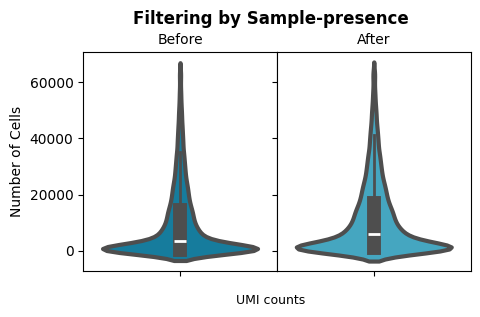

In [24]:
# preserve the QC metric in a variable for plotting
distr_before = alldata.var['n_cells_by_counts']

#filter out the genes in few samples
mask = alldata.var['gene_name'].isin(list_genes)
alldata = alldata[:, mask]

#save the new QC metric to another variable
distr_after = alldata.var['n_cells_by_counts']

In [ ]:
sc.pp.filter_genes(alldata, min_cells=100) # filter out genes which may be expressed in many samples but in too few cells after concatenation

We then identify highly expressed genes in the concatenated dataset as we did sample-specific at the Gene_filtering step and we do not notice any overpowering housekeeping genes. Since in the background pl.highest_expr_genes() works with matplotlib, we extract the genes from the y labels through matplotlib.

18079


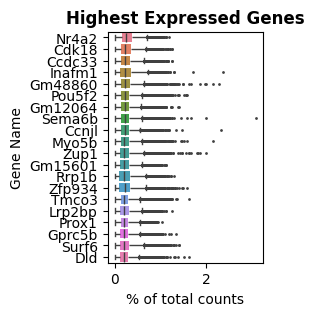

In [86]:
def heg(adata, n_top):
    '''
    Identify and plot highest expressed genes on a sample specific basis with scanpy. Then extract the gene names in a list.

    Args:
        adata (Anndata): Anndata object of a single sample
        n_top (int): number of genes to identify 
        
    Returns:
        list: list of str, highest expressed gene names (as gene symbols)
    '''
    fig, ax = plt.subplots(figsize=(2,3))
    sc.pl.highest_expr_genes(adata, gene_symbols='gene_name', n_top=20, show=False, ax=ax)
    for bar in ax.patches:
        bar.set_edgecolor("none")
        bar.set_linewidth(0)
    plt.title(f'Highest Expressed Genes', weight='bold')
    plt.ylabel('Gene Name')
    plt.savefig(f'new_data/plots/conc_qc/high_expr_conc.png', dpi=300, bbox_inches='tight')
    plt.show()

    # get highly expressed genes as a list to remove them if needed
    top_genes = [label.get_text() for label in ax.get_yticklabels()]
    return top_genes

We did not remove the top highly expressed genes from the dataset

In [ ]:
# remaining_genes = [gene for gene in conc_var['gene_name'] if gene not in top_genes]
# mask = alldata.var['gene_name'].isin(remaining_genes)
# alldata = alldata[:, mask]

Lastly after filtering we again try to visualise any remaining QC effects visible by ribosomal/mitochondrial counts. There is nothing obvious on the scatterplots, however we still visualise confounding covariates donwstream in order to be sure that any confounding effects are not still present.

In [93]:
def plot_pre(anndata, x_metric, ymetric, y_scale):
    '''
    Plot and save QC scatterplots with threshold lines before filtering of data. 

    Args:
        adata (Anndata): Concatenated anndata object
        x_metric (str): quality metric name (see prepare_for_qc()) for x
        y_metric (str): quality metric name (see prepare_for_qc()) for y
        y_scale (float): set limit for y axis for visibility

    Returns:
        None
    '''
    p = sc.pl.scatter(anndata, x=x_metric, y=y_metric, show=False)
    plt.xscale('log')
    p.set_ylim(0,y_scale)
    # p.set_xlim(6,12) #when plotting log1p_total_counts. Otherwise disable
    plt.ylabel(f"Percent {y_metric[11:]} counts")
    plt.xlabel(f"Total UMI counts")
    plt.title(label=f"data {y_metric[11:]} counts pre QC", weight='bold')
    # plt.savefig(f'new_data/pl_{y_metric[11:]}_alldata_pre.png', dpi=300)
    plt.show()
    plt.close()


def prepare_for_qc(adata):
    adata.obs_names_make_unique()
    adata.var["mito"] = adata.var['gene_name'].str.lower().str.startswith("mt-", na=False)
    adata.var["ribo"] = adata.var['gene_name'].str.lower().str.startswith(("rps", "rpl"), na=False)
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mito", "ribo"], inplace=True, percent_top=[20], log1p=True)
    adata.var_names_make_unique()
    return adata.copy()

    
def tresholds_n_filter(adata, dict_parameters, sample):
    ribo = 40
    mito = 10
    second_genes=5000
    # set thresholds 
    adata.obs['ribo_outlier'] = ((adata.obs['pct_counts_ribo'] > ribo) & \
                                 (adata.obs['log1p_total_counts'] < second_genes)) 
    adata.obs['mito_outlier'] = (adata.obs['pct_counts_mito'] > mito)
    return adata.copy()


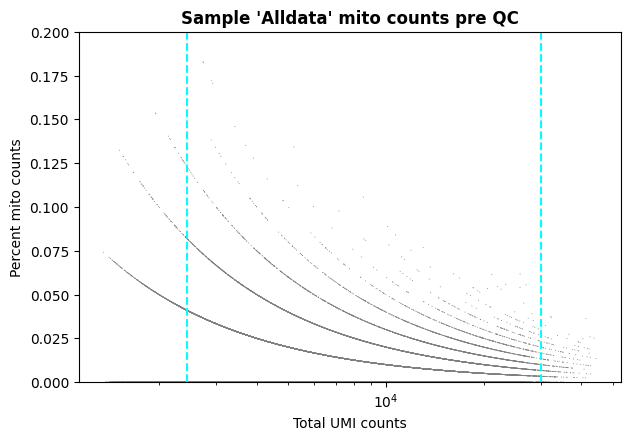

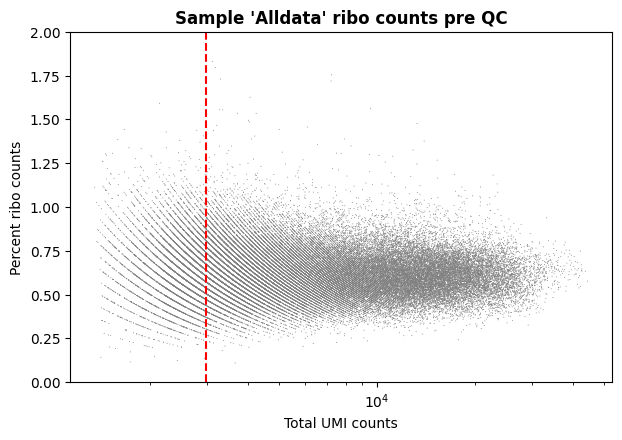

In [101]:
import numpy as np
data=prepare_for_qc(alldata)
plot_pre(data,"total_counts",'pct_counts_mito')
plot_pre(data,"total_counts",'pct_counts_ribo')

It is imperative to be sure that the counts were not affected by any of the priorly applied QC algorithms and that they are still the raw counts.

In [102]:
alldata.X.max() # check if raw counts in .X

1670.0

In [89]:
alldata.write_h5ad(f'new_data/concatenated_data/alldata.h5ad', compression='gzip') # export with raw counts in .X